In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('online_retail.csv', index_col=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Setting index to InvoiceDate using datetime

df.set_index(df.InvoiceDate, inplace=True)
df.index = pd.to_datetime(df.index)
df.drop(columns=['InvoiceDate'], inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [4]:
def expand_dt(df):
    df['time'] = df.index
    df['year'] = df.time.dt.year
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['day_of_month'] = df.time.dt.day
    df['day_of_week'] = df.time.dt.day_name().str[:3]
    df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) > 4)
    df['hour'] = df.index.hour
    df.drop(columns=['time'], inplace=True)
    return df


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Dropping negative quantity, they are returns.
df = df[df['Quantity']>0]

# dropping negative unit price, they are 'Adjust bad debt'
df = df[df['UnitPrice']>0]

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [8]:
df.shape

(530104, 7)

In [9]:
df['InvoiceTotal'] = df.Quantity * df.UnitPrice

In [10]:
df = expand_dt(df)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceTotal,year,quarter,month,day_of_month,day_of_week,is_weekend,hour
InvoiceDate,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,1,Wed,False,8


### Order Times

- Looks like orders steadly rise through the morning and peek at noon and 3pm then sharply fall off.


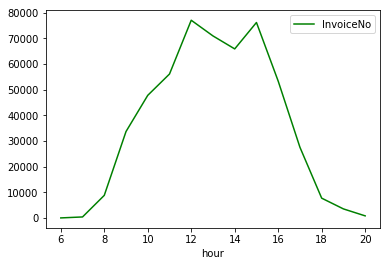

In [94]:
df.groupby('hour').count()[['InvoiceNo']].plot(color='green')

In [13]:
df.groupby('hour').count()[['InvoiceNo']].describe()

,InvoiceNo
count,15.000000
mean,35340.266667
std,30175.709783
min,1.000000
25%,5612.000000
50%,33701.000000
75%,61038.000000
max,77120.000000


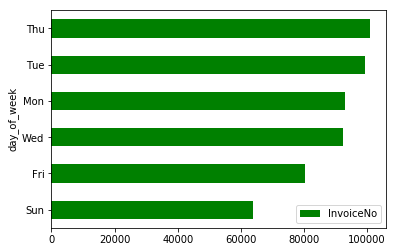

In [93]:
df.groupby('day_of_week').count()\
    [['InvoiceNo']].sort_values('InvoiceNo', ascending=False)\
    .sort_values('InvoiceNo').plot.barh(color='green')

### Order Count by Customer ID

- Average invoice total is 91 but is skewed by large orderes.
- The bulk of customers only have about less than 20 invoices.

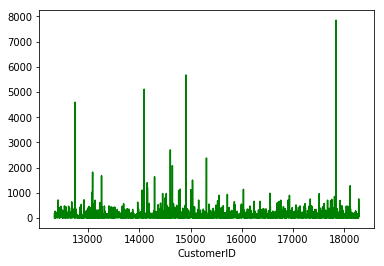

In [92]:
df.groupby('CustomerID').count()['InvoiceNo'].plot(color='green')


In [72]:
df.groupby('CustomerID').count()[['InvoiceNo']].describe()

,InvoiceNo
count,4338.000000
mean,91.720609
std,228.785094
min,1.000000
25%,17.000000
50%,41.000000
75%,100.000000
max,7847.000000


### Top 10 best selling items

- By Quantity

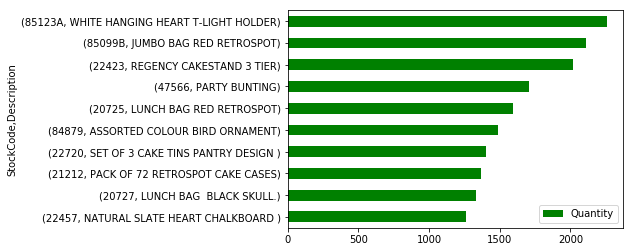

In [91]:
df[['StockCode','Description', 'Quantity']]\
    .groupby(['StockCode','Description']).count()\
    .sort_values('Quantity', ascending=False).head(10)\
    .sort_values('Quantity').plot.barh(color='green')


- By InvoiceTotal

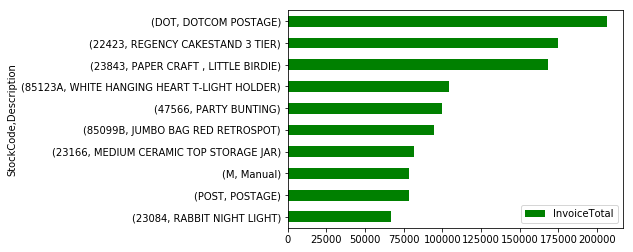

In [90]:
df[['StockCode','Description', 'InvoiceTotal']]\
    .groupby(['StockCode','Description']).sum()\
    .sort_values('InvoiceTotal', ascending=False).head(10)\
    .sort_values('InvoiceTotal').plot.barh(color='green')

In [96]:
basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']\
              .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,3 ROSE MORRIS BOXED CANDLES,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAL COOKIE CUTTERS SET,3 TRADITIONAl BISCUIT CUTTERS SET,3 WHITE CHOC MORRIS BOXED CANDLES,3 WICK CHRISTMAS BRIAR CANDLE,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE POSY,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D DOG PICTURE PLAYING CARDS,3D HEARTS HONEYCOMB PAPER GARLAND,3D SHEET OF CAT STICKERS,3D SHEET OF DOG STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 BLUE DINNER CANDLES SILVER FLOCK,4 BURGUNDY WINE DINNER CANDLES,4 GOLD FLOCK CHRISTMAS BALLS,4 IVORY DINNER CANDLES SILVER FLOCK,4 LAVENDER BOTANICAL DINNER CANDLES,4 LILY BOTANICAL DINNER CANDLES,4 PEAR BOTANICAL DINNER CANDLES,4 PINK DINNER CANDLE SILVER FLOCK,4 PINK FLOCK CHRISTMAS BALLS,4 ROSE PINK DINNER CANDLES,4 SKY BLUE DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,4 VANILLA BOTANICAL CANDLES,4 WILDFLOWER BOTANICAL CANDLES,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,5 STRAND GLASS NECKLACE AMBER,5 STRAND GLASS NECKLACE AMETHYST,5 STRAND GLASS NECKLACE BLACK,5 STRAND GLASS NECKLACE CRYSTAL,50'S CHRISTMAS PAPER GIFT BAG,50CM METAL STRING WITH 7 CLIPS,6 CHOCOLATE LOVE HEART T-LIGHTS,6 EGG HOUSE PAINTED WOOD,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS ELEGANT CHRISTMAS,6 RIBBONS EMPIRE,6 RIBBONS RUSTIC CHARM,6 RIBBONS SHIMMERING PINKS,6 ROCKET BALLOONS,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 GOLD AND SILVER FAIRY CAKE CASES,60 TEATIME FAIRY CAKE CASES,6PC WOOD PLATE SET DISPOSABLE,70'S ALPHABET WALL ART,72 CAKE CASES VINTAGE CHRISTMAS,72 SWEETHEART FAIRY CAKE CASES,75 BLACK PETIT FOUR CASES,75 GREEN FAIRY CAKE CASES,75 GREEN PETIT FOUR CASES,A PRETTY THANK YOU CARD,A4 WALL TIDY BLUE OFFICE,A4 WALL TIDY RED FLOWERS,ABC TREASURE BOOK BOX,ABSTRACT CIRCLE JOURNAL,ABSTRACT CIRCLES POCKET BOOK,ABSTRACT CIRCLES SKETCHBOOK,ACRYLIC GEOMETRIC LAMP,"ACRYLIC HANGING JEWEL,BLUE","ACRYLIC HANGING JEWEL,PINK","ACRYLIC JEWEL ANGEL,PINK","ACRYLIC JEWEL ICICLE, BLUE","ACRYLIC JEWEL ICICLE, PINK","ACRYLIC JEWEL SNOWFLAKE, PINK","ACRYLIC JEWEL SNOWFLAKE,PINK",ADULT APRON APPLE DELIGHT,ADVENT CALENDAR GINGHAM SACK,AFGHAN SLIPPER SOCK PAIR,AGED GLASS SILVER T-LIGHT

In [104]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.drop('DOTCOM POSTAGE', inplace=True, axis=1)

In [105]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

frequent_itemsets.head()

,support,itemsets
0,0.013477,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.015932,(10 COLOUR SPACEBOY PEN)
2,0.012575,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.017786,(12 PENCIL SMALL TUBE WOODLAND)
4,0.018136,(12 PENCILS SMALL TUBE RED RETROSPOT)


In [106]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JAM MAKING SET PRINTED),(6 RIBBONS RUSTIC CHARM),0.058216,0.047846,0.011824,0.203098,4.244857,0.009038,1.194820
1,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET PRINTED),0.047846,0.058216,0.011824,0.247120,4.244857,0.009038,1.250909
2,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET WITH JARS),0.047846,0.056713,0.010371,0.216754,3.821916,0.007657,1.204330
3,(JAM MAKING SET WITH JARS),(6 RIBBONS RUSTIC CHARM),0.056713,0.047846,0.010371,0.182862,3.821916,0.007657,1.165231
4,(6 RIBBONS RUSTIC CHARM),(JUMBO BAG RED RETROSPOT),0.047846,0.104659,0.010872,0.227225,2.171093,0.005864,1.158605


In [114]:
rules[ (rules['confidence'] >= 0.75) ].sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1842,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010671,0.012024,0.010170,0.953052,79.262128,0.010042,21.043888
1836,"(HERB MARKER BASIL, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010521,0.012024,0.010020,0.952381,79.206349,0.009894,20.747495
2796,"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE P...",(REGENCY TEA PLATE GREEN ),0.013477,0.019088,0.012776,0.947955,49.661915,0.012518,18.847520
1841,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010772,0.011874,0.010170,0.944186,79.518791,0.010042,17.703929
1834,"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",(HERB MARKER THYME),0.010721,0.011874,0.010020,0.934579,78.709728,0.009893,15.104216
425,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011874,0.012024,0.011072,0.932489,77.552039,0.010929,14.634394
2819,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN T...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.012475,0.025651,0.011573,0.927711,36.166227,0.011253,13.478490
424,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.012024,0.011874,0.011072,0.920833,77.552039,0.010929,12.481595
2867,"(CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOT...",(RED RETROSPOT CHARLOTTE BAG),0.013176,0.051703,0.012124,0.920152,17.796740,0.011443,11.876286
3052,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",(RED RETROSPOT CHARLOTTE BAG),0.011122,0.051703,0.010220,0.918919,17.772889,0.009645,11.695658


In [108]:
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceTotal,year,quarter,month,day_of_month,day_of_week,is_weekend,hour
InvoiceDate,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850.0,United Kingdom,15.30,2010,4,12,1,Wed,False,8
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom,25.50,2010,4,12,1,Wed,False,8
2010-12-01 08:28:00,536366,22633,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,11.10,2010,4,12,1,Wed,False,8
2010-12-01 08:28:00,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850.0,United Kingdom,11.10,2010,4,12,1,Wed,False,8
